# Multi-Factor Timing with Deep Learning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

In [ ]:
# Model Architecture
class MultiFactorModel(nn.Module):
    def __init__(self, num_macro_features, num_fin_features, num_factors):
        super().__init__()
        self.lstm_macro = nn.LSTM(num_macro_features, 32)
        self.lstm_fin = nn.LSTM(num_fin_features, 16)
        self.dense1 = nn.Linear(32 + 16, 64)
        self.factor_branches = nn.ModuleDict()
        for factor in num_factors:
            self.factor_branches[factor] = nn.Sequential(nn.Linear(64, 32), nn.Linear(32, 1))

    def forward(self, macro_data, fin_data):
        X_macro, _ = self.lstm_macro(macro_data)
        X_fin, _ = self.lstm_fin(fin_data)
        X_combined = torch.cat([X_macro, X_fin], dim=1)
        X = self.dense1(X_combined)
        outputs = {}
        for factor, branch in self.factor_branches.items():
            outputs[factor] = branch(X)
        return outputs

In [ ]:
# Data Preprocessing
lookback = 20
threshold = -1.618
cutoff = 0.25
val_index = 660 #720
test_index = 720 #val_index #825

df_cdx = pd.read_csv('CDX_Index.csv', index_col=['Dates'], parse_dates=['Dates'])
df_hy = pd.read_csv('HY_Industry.csv', index_col=['Dates'], parse_dates=['Dates'])
df_xa = pd.read_csv('HY_XAssets.csv', index_col=['Dates'], parse_dates=['Dates'])

def getPercentile(df, lookback=1000):
    # https://stackoverflow.com/questions/68831145/fast-way-to-get-rolling-percentile-ranks
    data = df.to_numpy()
    sw = np.lib.stride_tricks.sliding_window_view(data, lookback, axis=0).T
    scores_np = (sw <= sw[-1:, ...]).sum(axis=0).T / sw.shape[0]
    nan_nparray = np.empty((lookback-1, df.shape[1]))
    nan_nparray[:] = np.nan
    scores_np_full = np.insert(scores_np, 0, nan_nparray, axis=0)
    scores_np_df = pd.DataFrame(scores_np_full, columns=df.columns, index=df.index)
    return scores_np_df

df_X = getPercentile(df_hy.join(df_xa, how='left'), lookback)
df_X1 = df_X[df_xa.columns]
df_X2 = df_X[df_hy.columns]

df_Ret = df_cdx.pct_change(periods=1)
df_Wgt = df_cdx.pct_change(periods=1)

df_Y = df_cdx.pct_change(periods=4).shift(-2)
df_Label = df_Y < threshold/100
df_Label = df_Label.astype(int)

train_X = df_X.iloc[lookback:val_index]
val_X = df_X.iloc[val_index:test_index]
test_X = df_X.iloc[test_index:]
train_X1 = df_X1.iloc[lookback:val_index]
val_X1 = df_X1.iloc[val_index:test_index]
test_X1 = df_X1.iloc[test_index:]
train_X2 = df_X2.iloc[lookback:val_index]
val_X2 = df_X2.iloc[val_index:test_index]
test_X2 = df_X2.iloc[test_index:]

train_Y = df_Y.iloc[lookback:val_index]
val_Y = df_Y.iloc[val_index:test_index]
test_Y = df_Y.iloc[test_index:]
train_Label = df_Label.iloc[lookback:val_index]
val_Label = df_Label.iloc[val_index:test_index]
test_Label = df_Label.iloc[test_index:]

scaler = StandardScaler()
train_X_tensor = torch.from_numpy(scaler.fit_transform(train_X))
val_X_tensor = torch.from_numpy(scaler.fit_transform(val_X))
test_X_tensor = torch.from_numpy(scaler.transform(test_X))
train_X1_tensor = torch.from_numpy(scaler.fit_transform(train_X1))
val_X1_tensor = torch.from_numpy(scaler.fit_transform(val_X1))
test_X1_tensor = torch.from_numpy(scaler.transform(test_X1))
train_X2_tensor = torch.from_numpy(scaler.fit_transform(train_X2))
val_X2_tensor = torch.from_numpy(scaler.fit_transform(val_X2))
test_X2_tensor = torch.from_numpy(scaler.transform(test_X2))

num_macro_features = len(df_xa.columns)
num_fin_features = len(df_hy.columns)
num_factors = df_cdx.columns

train_macro = train_X1_tensor.to(torch.float32)
train_fin = train_X2_tensor.to(torch.float32)
val_macro = val_X1_tensor.to(torch.float32)
val_fin = val_X2_tensor.to(torch.float32)
test_macro = test_X1_tensor.to(torch.float32)
test_fin = test_X2_tensor.to(torch.float32)

In [ ]:
# Calibrating learning rate
num_epochs = 100
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.000005, 0.000001] #[0.01, 0.001, 0.0001]
train_err = torch.zeros(len(learning_rates))
val_err = torch.zeros(len(learning_rates))
test_err = torch.zeros(len(learning_rates))
models = []

for i, learning_rate in enumerate(learning_rates):
    model = MultiFactorModel(num_macro_features, num_fin_features, num_factors)
    bce_loss = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model.forward(train_macro, train_fin)
        loss = 0
        for factor in outputs:
            loss += bce_loss(outputs[factor], torch.FloatTensor(train_Label[factor].values).view(-1, 1))
        train_err[i] += loss/len(train_Label)
        loss.backward()
        optimizer.step()

        val_outputs = model(val_macro, val_fin)
        val_loss = 0
        for factor in val_outputs:
            val_loss += bce_loss(val_outputs[factor], torch.FloatTensor(val_Label[factor].values).view(-1, 1))
        val_err[i] += val_loss/len(val_Label)

        test_outputs = model(test_macro, test_fin)
        test_loss = 0
        for factor in test_outputs:
            test_loss += bce_loss(test_outputs[factor], torch.FloatTensor(test_Label[factor].values).view(-1, 1))
        test_err[i] += test_loss/len(test_Label)

    train_err[i] /= epoch
    val_err[i] /= epoch
    test_err[i] /= epoch

    models.append(model)

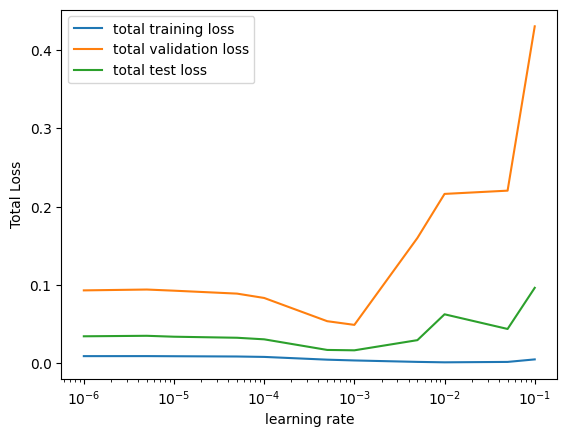

In [ ]:
plt.semilogx(np.array(learning_rates), train_err.tolist(), label = 'total training loss')
plt.semilogx(np.array(learning_rates), val_err.tolist(), label = 'total validation loss')
plt.semilogx(np.array(learning_rates), test_err.tolist(), label = 'total test loss')
plt.ylabel('Total Loss')
plt.xlabel('learning rate')
plt.legend()
plt.show()

In [ ]:
# Training
learning_rate = 0.001
num_epochs = 100
num_rounds = 20
train_err = torch.zeros(num_rounds)
val_err = torch.zeros(num_rounds)
test_err = torch.zeros(num_rounds)
models = []

for i in range(num_rounds):
    model = MultiFactorModel(num_macro_features, num_fin_features, num_factors)
    bce_loss = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model.forward(train_macro, train_fin)
        loss = 0
        for factor in outputs:
            loss += bce_loss(outputs[factor], torch.FloatTensor(train_Label[factor].values).view(-1, 1))
        train_err[i] += loss/len(train_Label)
        loss.backward()
        optimizer.step()

        val_outputs = model(val_macro, val_fin)
        val_loss = 0
        for factor in val_outputs:
            val_loss += bce_loss(val_outputs[factor], torch.FloatTensor(val_Label[factor].values).view(-1, 1))
        val_err[i] += val_loss/len(val_Label)

        test_outputs = model(test_macro, test_fin)
        test_loss = 0
        for factor in test_outputs:
            test_loss += bce_loss(test_outputs[factor], torch.FloatTensor(test_Label[factor].values).view(-1, 1))
        test_err[i] += test_loss/len(test_Label)

    train_err[i] /= epoch
    val_err[i] /= epoch
    test_err[i] /= epoch

    models.append(model)

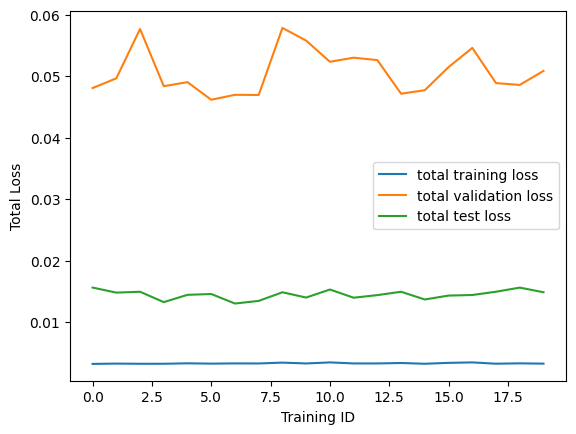

In [ ]:
plt.plot(np.array(range(num_rounds)), train_err.tolist(), label = 'total training loss')
plt.plot(np.array(range(num_rounds)), val_err.tolist(), label = 'total validation loss')
plt.plot(np.array(range(num_rounds)), test_err.tolist(), label = 'total test loss')
plt.ylabel('Total Loss')
plt.xlabel('Training ID')
plt.legend()
plt.show()

In [ ]:
# Testing out of sample
model = models[6]

with torch.no_grad():
    train_outputs = model(train_macro, train_fin)
    train_probs = {k: torch.sigmoid(v).flatten().tolist() for k, v in train_outputs.items()}
    val_outputs = model(val_macro, val_fin)
    val_probs = {k: torch.sigmoid(v).flatten().tolist() for k, v in val_outputs.items()}
    test_outputs = model(test_macro, test_fin)
    test_probs = {k: torch.sigmoid(v).flatten().tolist() for k, v in test_outputs.items()}

for factor in df_Wgt.columns:
    tmp_probs = [np.nan]*lookback + train_probs[factor] + val_probs[factor] + test_probs[factor]
    df_Wgt[factor] = pd.Series(tmp_probs, index=df_Wgt.index, name=factor) > cutoff

df_Hedge = - df_Wgt.shift(1) * df_Ret
df_Hedged = (1 - df_Wgt.shift(1)) * df_Ret
df_LongShort = (1 - 2 * df_Wgt.shift(1)) * df_Ret
df1 = (1 + df_Ret[df_Wgt.columns[-3:]][val_index:]).cumprod() - 1
df2 = (1 + df_Hedge[df_Wgt.columns[-3:]][val_index:]).cumprod() - 1
df3 = (1 + df_Hedged[df_Wgt.columns[-3:]][val_index:]).cumprod() - 1
df4 = (1 + df_LongShort[df_Wgt.columns[-3:]][val_index:]).cumprod() - 1

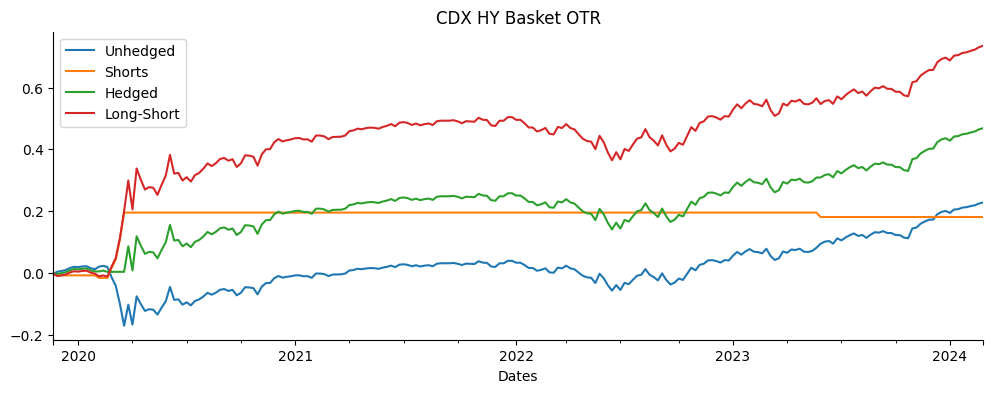

In [ ]:
factor = 'CDX HY Basket OTR'
df1[factor].plot(kind='line', figsize=(12, 4), label='Unhedged')
df2[factor].plot(kind='line', figsize=(12, 4), label='Shorts')
df3[factor].plot(kind='line', figsize=(12, 4), label='Hedged')
df4[factor].plot(kind='line', figsize=(12, 4), label='Long-Short')
plt.title(factor)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
torch.save(model.state_dict(), "cdx_lstm.pt")

In [ ]:
model = MultiFactorModel(num_macro_features, num_fin_features, num_factors)
model.load_state_dict(torch.load("cdx_lstm.pt"))

<All keys matched successfully>

In [ ]:
# Predictions
with torch.no_grad():
    train_outputs = model(train_macro, train_fin)
    train_probs = {k: torch.sigmoid(v).flatten().tolist() for k, v in train_outputs.items()}
    val_outputs = model(val_macro, val_fin)
    val_probs = {k: torch.sigmoid(v).flatten().tolist() for k, v in val_outputs.items()}
    test_outputs = model(test_macro, test_fin)
    test_probs = {k: torch.sigmoid(v).flatten().tolist() for k, v in test_outputs.items()}

# Portfolio Construction
for factor in df_Wgt.columns:
    tmp_probs = [np.nan]*lookback + train_probs[factor] + val_probs[factor] + test_probs[factor]
    df_Wgt[factor] = pd.Series(tmp_probs, index=df_Wgt.index, name=factor) > cutoff

df_Hedge = - df_Wgt.shift(1) * df_Ret
df_Hedged = (1 - df_Wgt.shift(1)) * df_Ret
df_LongShort = (1 - 2 * df_Wgt.shift(1)) * df_Ret
df1 = (1 + df_Ret[df_Wgt.columns[-3:]]).cumprod() - 1
df2 = (1 + df_Hedge[df_Wgt.columns[-3:]]).cumprod() - 1
df3 = (1 + df_Hedged[df_Wgt.columns[-3:]]).cumprod() - 1
df4 = (1 + df_LongShort[df_Wgt.columns[-3:]]).cumprod() - 1

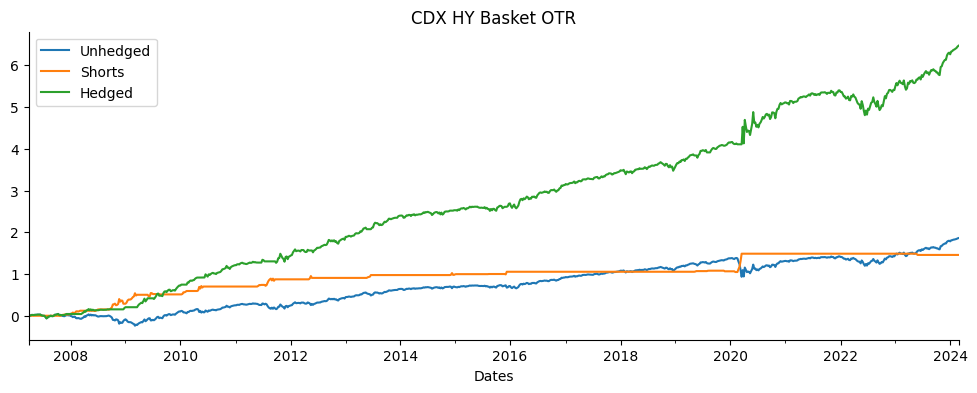

In [ ]:
factor = 'CDX HY Basket OTR'
df1[factor].plot(kind='line', figsize=(12, 4), label='Unhedged')
df2[factor].plot(kind='line', figsize=(12, 4), label='Shorts')
df3[factor].plot(kind='line', figsize=(12, 4), label='Hedged')
#df4[factor].plot(kind='line', figsize=(12, 4), label='Long-Short')
plt.title(factor)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)

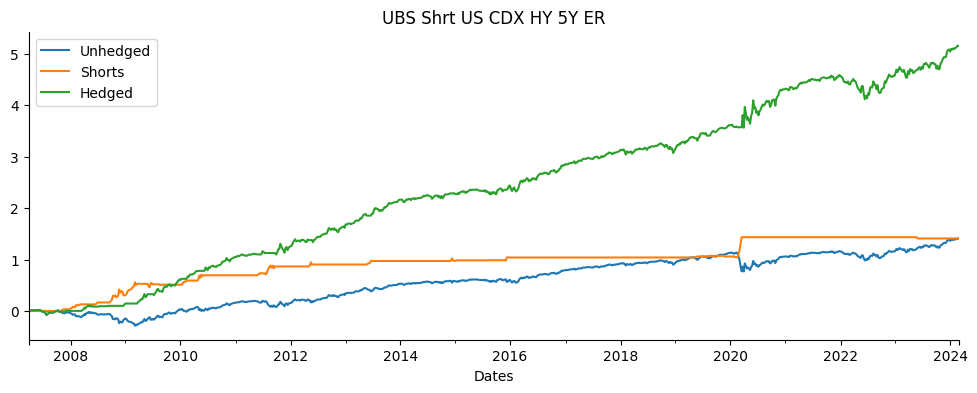

In [ ]:
factor = 'UBS Shrt US CDX HY 5Y ER'
df1[factor].plot(kind='line', figsize=(12, 4), label='Unhedged')
df2[factor].plot(kind='line', figsize=(12, 4), label='Shorts')
df3[factor].plot(kind='line', figsize=(12, 4), label='Hedged')
#df4[factor].plot(kind='line', figsize=(12, 4), label='Long-Short')
plt.title(factor)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)

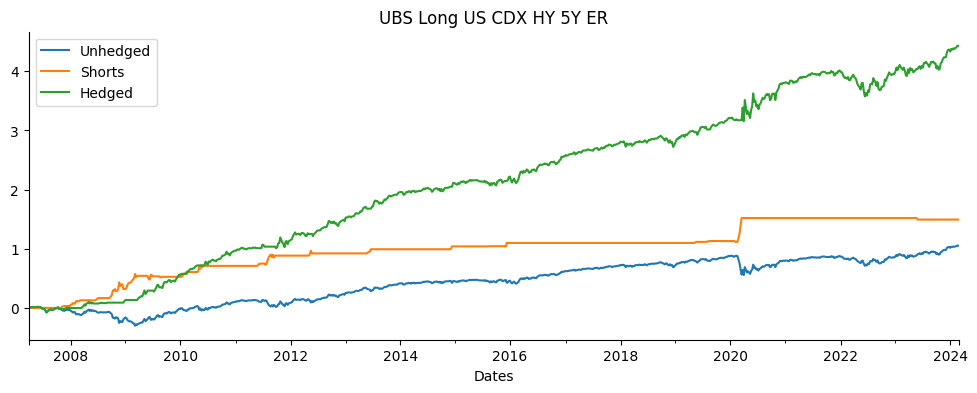

In [ ]:
factor = 'UBS Long US CDX HY 5Y ER'
df1[factor].plot(kind='line', figsize=(12, 4), label='Unhedged')
df2[factor].plot(kind='line', figsize=(12, 4), label='Shorts')
df3[factor].plot(kind='line', figsize=(12, 4), label='Hedged')
#df4[factor].plot(kind='line', figsize=(12, 4), label='Long-Short')
plt.title(factor)
plt.legend()
plt.gca().spines[['top', 'right']].set_visible(False)